In [1]:
import sys
sys.path.insert(1, '..')
from utils import *
from netsmile import *

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'
network_dir = join(pwd, dpath, 'mobility-networks', f'{AREA_NAME}-CBG-CBG-Nets-msa')
nets = load_networks(network_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:53<00:00,  2.00it/s]


In [3]:
week_id = []
for obs in nets:
    week_id.append(obs[0].isocalendar()[1])
    
nets = np.hstack([nets, np.array(week_id).reshape(-1, 1)])

In [4]:
msa_counties = pd.read_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-msa']))['fips'].astype(np.int64)

In [5]:
nyc_boroughs = set([str(i) for i in nyc_fips2borough.keys()])

In [6]:
census_data = join(pwd, util_datasets, datasets['census-data'])
census_quartiles, census_raw = get_census_attributes(census_data, msa_counties)

In [7]:
n19 = nets[:52]
n20 = nets[52:52*2 - 3]
# align the dates wrt week numbers
n19 = n19[[ind for ind, w in enumerate(n19[:, 2]) if w in n20[:, 2]]]

In [40]:
rows = []
for net19, net20 in tqdm(zip(n19, n20), total=len(n20)):
    nodes = [cbg for cbg in np.intersect1d(net19[1].vs['name'], net20[1].vs['name']) if cbg[:5] in nyc_boroughs]
    f1 = get_netsmile_features(net19[1], nodes)
    f2 = get_netsmile_features(net20[1], nodes)
    for u, v, n in zip(f1, f2, nodes):
        rows.append({
            'date': net20[0],
            'cbg': n,
            'dissimilarity': distance.canberra(u,v)})
        
pd.DataFrame(rows).to_csv(join(pwd, util_datasets, datasets['node-dissimilarity']), index=False)

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [1:36:27<00:00, 118.12s/it]


In [8]:
df = pd.read_csv(join(pwd, util_datasets, datasets['node-dissimilarity']))
df.head()

,date,cbg,dissimilarity
0,2019-12-30,360050001001,0.709145
1,2019-12-30,360050002001,0.806917
2,2019-12-30,360050002002,0.375474
3,2019-12-30,360050002003,0.470529
4,2019-12-30,360050004001,0.282022


Text(0.5, 0.98, 'Weekly Dissimilarity Between Paired Networks of 2019 & 2020')

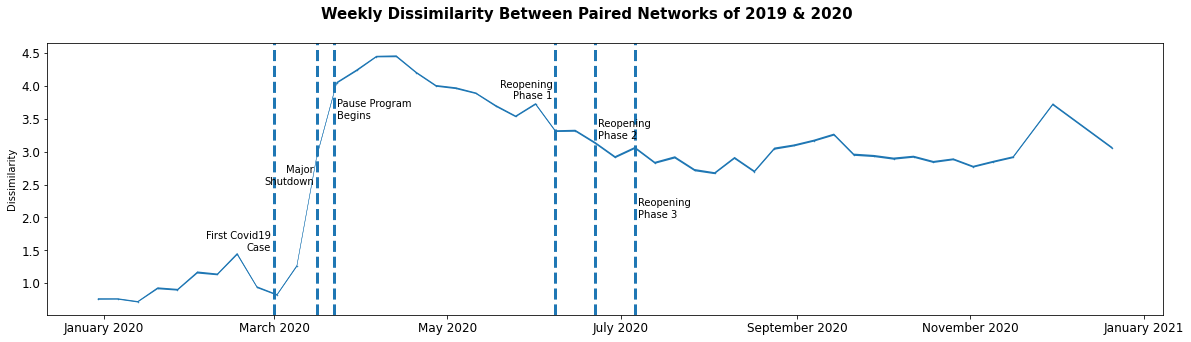

In [8]:
ddf = df.copy()
ddf['date'] = pd.to_datetime(ddf['date'])

timeline = [
    ("2020-03-01", "First Covid19\nCase", 1.5, "right"),
    ("2020-03-16", "Major\nShutdown", 2.5, "right"),
    ("2020-03-22", "Pause Program\nBegins", 3.5, "left"),
    ("2020-06-08", "Reopening\nPhase 1", 3.8, "right"),
    ("2020-06-22", "Reopening\nPhase 2", 3.2, "left"),
    ("2020-07-06", "Reopening\nPhase 3", 2, "left"),
]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

monthf = mdates.DateFormatter('%B %Y')
dis_change = ddf.groupby('date')['dissimilarity']
change_ci = dis_change.apply(bootstrap_ci).values
dis_change = dis_change.mean()

ax.plot(dis_change.index, dis_change.values, marker='o', linewidth=0.5, markersize=0.5)
ax.fill_between(dis_change.index, [i[0] for i in change_ci], [i[1] for i in change_ci])
ax.set_ylabel('Dissimilarity')
ax.set_xlabel(None)
ax.xaxis.set_major_formatter(monthf)
ax.tick_params(labelsize=12)

for d, s, h, r in timeline:
    ax.axvline(datetime.strptime(d, '%Y-%m-%d'), linestyle='--', linewidth=3)
    dt = 1
    if r == 'left':
        dt = -1
    ax.text(datetime.strptime(d, "%Y-%m-%d") - timedelta(days=dt), h, s, {"fontsize": 10}, horizontalalignment=r)
    
fig.suptitle('Weekly Dissimilarity Between Paired Networks of 2019 & 2020', fontsize=15, fontweight='bold')
#fig.savefig(join(FIG_SAVE_DIR, 'overall_change.png'))

Text(0.5, 1.05, 'Weekly Dissimilarity Between Paired Networks of 2019 & 2020')

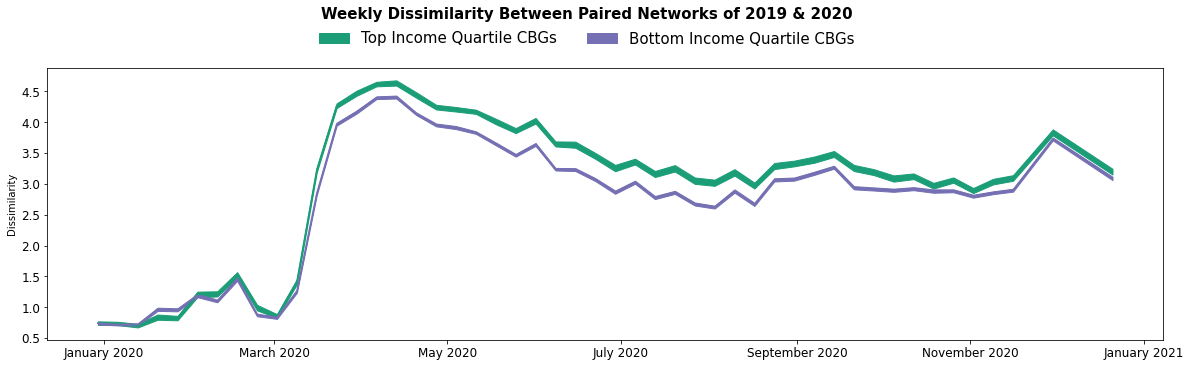

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

top_cbgs = census_quartiles[census_quartiles['income-quartile'] == 'Top'].census_block_group.values
bottom_cbgs = census_quartiles[census_quartiles['income-quartile'] == 'Bottom'].census_block_group.values

monthf = mdates.DateFormatter('%B %Y')

top_dgroup = ddf[ddf['cbg'].isin(top_cbgs)].groupby('date')['dissimilarity']
bottom_dgroup = ddf[ddf['cbg'].isin(bottom_cbgs)].groupby('date')['dissimilarity']

top_ci = top_dgroup.apply(bootstrap_ci, stat=np.mean).values
bottom_ci = bottom_dgroup.apply(bootstrap_ci, stat=np.mean).values

top_change = top_dgroup.mean()
bottom_change = bottom_dgroup.mean()

ax.plot(top_change.index, top_change.values, color=colors['top_color'])
ax.fill_between(top_change.index, [i[0] for i in top_ci], [i[1] for i in top_ci], color=colors['top_color'])

ax.plot(bottom_change.index, bottom_change.values, color=colors['bottom_color'])
ax.fill_between(bottom_change.index, [i[0] for i in bottom_ci], [i[1] for i in bottom_ci], color=colors['bottom_color'])

ax.set_ylabel('Dissimilarity')
ax.set_xlabel(None)
ax.xaxis.set_major_formatter(monthf)
ax.tick_params(labelsize=12)

# for d, s, h, r in timeline:
#     ax.axvline(datetime.strptime(d, '%Y-%m-%d'), linestyle='--', linewidth=3)
#     dt = 1
#     if r == 'left':
#         dt = -1
#     ax.text(datetime.strptime(d, "%Y-%m-%d") - timedelta(days=dt), h, s, {"fontsize": 10}, horizontalalignment=r)
    
top_patch = mpatches.Patch(color=colors['top_color'])
bottom_patch = mpatches.Patch(color=colors['bottom_color']) 
    
fig.legend([top_patch, bottom_patch],
            [f'Top Income Quartile CBGs', 
            f'Bottom Income Quartile CBGs'],
            bbox_to_anchor=(0.695, 1.02), ncol=2,edgecolor='white', fontsize=15, title_fontsize=20)
    
fig.suptitle('Weekly Dissimilarity Between Paired Networks of 2019 & 2020', y=1.05, fontsize=15, fontweight='bold')
#fig.savefig(join(FIG_SAVE_DIR, 'overall_change_income.png'), bbox_inches='tight', dpi=150)

In [60]:
df.date.unique()

array(['2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20',
       '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17',
       '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16',
       '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13',
       '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11',
       '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08',
       '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06',
       '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03',
       '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31',
       '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28',
       '2020-10-05', '2020-10-12', '2020-10-19', '2020-10-26',
       '2020-11-02', '2020-11-09', '2020-11-16', '2020-11-30',
       '2020-12-21'], dtype=object)

In [52]:
quartiles = ['bottom', 'third', 'second', 'top']
top_candidates = []
bottom_candidates = []
# start from march
dates = df.date.unique()[10:24]
for date in tqdm(dates):
    sel_df = df[df.date == date]
    sel_df['labels'] = pd.qcut(sel_df['dissimilarity'], 4, labels=quartiles)
    top_candidates.append(set(sel_df[sel_df['labels'] == 'top']['cbg'].values))
    bottom_candidates.append(set(sel_df[sel_df['labels'] == 'bottom']['cbg'].values))
    
# quartiles = ['bottom', 'third', 'second', 'top']
# quarts = []
# date_groups = df.groupby('date').groups
# for date in tqdm(date_groups):
#     ind = date_groups[date].tolist()
#     q = pd.qcut(df.loc[ind]['dissimilarity'], 4, labels=quartiles).rename('quartile')
#     quarts.append(q)
    
# qdf = pd.concat([df, pd.concat(quarts, axis=0)], axis=1)

# nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
# base_df = gpd.read_file(nyc_geojson)

# top_color = '#1b9e77'
# bottom_color = '#7570b3'

# for date, ind in tqdm(qdf.groupby('date').groups.items()):
#     sel_date = qdf.loc[ind]
#     top_cbgs = set(sel_date[sel_date['quartile'] == 'top']['cbg'].values)
#     bottom_cbgs = set(sel_date[sel_date['quartile'] == 'bottom']['cbg'].values)
    
#     fig, base_ax = plt.subplots(1,1,figsize=(15,10))
#     base_ax.axis('off')
        
#     base_df[base_df.BLKGRPCE != '0'].plot(color='#bdbdbd', ax=base_ax)
#     base_df[base_df.GEOID.astype(np.int64).isin(top_cbgs)].plot(color=top_color, ax=base_ax)
#     base_df[base_df.GEOID.astype(np.int64).isin(bottom_cbgs)].plot(color=bottom_color, ax=base_ax)
#     fig.savefig(join(FIG_SAVE_DIR, 'weekly-dissimilarity-maps', f'{date}.png'))
#     plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50.91it/s]


In [53]:
all_cbgs = set(df.cbg.values)
# how frequently a cbg appears in the top/bottom quartiles
threshold = 0.6
ntimesteps = len(dates)

top_cbgs = []
bottom_cbgs = []

for cbg in tqdm(all_cbgs):
    top_count = 0
    bottom_count = 0
    
    # check how many times the current cbg appears in the top candidates
    # here t is a set object that stores the cbg that appeared in the top quartile
    # for the given time step
    for t in top_candidates:
        if cbg in t:
            top_count += 1
            
    # same task for the bottom candidates
    for t in bottom_candidates:
        if cbg in t:
            bottom_count += 1
            
    # retrieve the ones exceeding the frequency threshold
    if (top_count / ntimesteps) >= threshold:
        top_cbgs.append(cbg)
        
    if (bottom_count / ntimesteps) >= threshold:
        bottom_cbgs.append(cbg)

100%|██████████████████████████████████████████████████████████████████████████| 5988/5988 [00:00<00:00, 133056.57it/s]


In [54]:
discard_borough = ['085']
filtered_top_cbgs = [cbg for cbg in top_cbgs if str(cbg)[2:5] not in discard_borough]
filtered_bottom_cbgs = [cbg for cbg in bottom_cbgs if str(cbg)[2:5] not in discard_borough]

In [55]:
nyc_census = census_raw[census_raw.census_block_group.astype(str).str[:5].isin(nyc_boroughs)]
col_names = census_raw.columns[1:]
quart = ['Bottom', 'Third', 'Second', 'Top']
for col in col_names:
    nyc_census[f'{col}-quartile'] = pd.qcut(nyc_census[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

In [57]:
def plot_cbgs_bar(top_cbgs, bottom_cbgs, fname=None, drop_row=None):
    '''
    plots the resulting cbgs in top/bottom dissimilarity groups
    and also the demographic distributions
    '''
    nyc_geojson = join(pwd, util_datasets, AREA_NAME, datasets['nyc-shapefile'])
    base_df = gpd.read_file(nyc_geojson)
    
    if drop_row:
        base_df = base_df.drop(drop_row)
    
    top_color = '#1b9e77'
    bottom_color = '#7570b3'
    bottom_no_staten_island_color = '#d4b1da'
    marker_size = 10
    tick_fontsize = 20
    
    nrows = 10
    ncols = 20
    hatch = '\\'
    
    fig = plt.figure(constrained_layout=True, figsize=(30, 12))
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    
    demo_cols = [('income', 'Income'), ('education', 'Education'), ('mean_time_to_work', 'Commute Time'), ('white_population', 'White Population')]
    top_sel_census = nyc_census[nyc_census.census_block_group.isin(top_cbgs)]
    bottom_sel_census = nyc_census[nyc_census.census_block_group.isin(bottom_cbgs)]
    bottom_sel_census_no_staten_island = bottom_sel_census[bottom_sel_census.census_block_group.astype(str).apply(lambda x: x[2:5] != '085')]

    for ind, (col, title) in enumerate(demo_cols):
        ix = (ind // 2)*4 + 2
        jx = (ind % 2)*4 + 12

        ax = fig.add_subplot(spec[ix:ix + 4, jx:jx + 4])

        t = top_sel_census[f'{col}-quartile'].value_counts(normalize=True)[['Bottom', 'Third', 'Second', 'Top']].rename('CBGs Changed the Most')
        b = bottom_sel_census[f'{col}-quartile'].value_counts(normalize=True)[['Bottom', 'Third', 'Second', 'Top']].rename('CBGs Changed the Least')
        b_nSI = bottom_sel_census_no_staten_island[f'{col}-quartile'].value_counts(normalize=True)[['Bottom', 'Third', 'Second', 'Top']].rename('CBGs Changed the Least - Staten Island Removed')
        
        print(col)
        print('top')
        print(t)
        print('bottom')
        print(b)
        print()
        
        pd.concat([b, t], axis=1).plot.barh(ax=ax, color=[bottom_color, top_color], legend=None)
        
        bars = ax.patches
        hatches = ''.join(h*4 for h in ['', '', hatch])
            
        ax.grid(axis='x', color='#bdbdbd', linestyle='--')
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        #ax.set_ylabel('Quartiles', fontsize=tick_fontsize)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.set_title(f'{title} Quartiles', fontsize=tick_fontsize)
    
    base_ax = fig.add_subplot(spec[:, :12])
    base_ax.axis('off')
        
    base_df[base_df.BLKGRPCE != '0'].plot(color='#bdbdbd', ax=base_ax)
    base_df[base_df.GEOID.astype(np.int64).isin(top_cbgs)].plot(color=top_color, ax=base_ax)
    base_df[base_df.GEOID.astype(np.int64).isin(bottom_cbgs)].plot(color=bottom_color, ax=base_ax)
    
    top_patch = mpatches.Patch(color=top_color)
    bottom_patch = mpatches.Patch(color=bottom_color)
    bottom_patch_no_staten_island = mpatches.Patch(facecolor=bottom_no_staten_island_color, hatch=hatch)

    fig.legend([top_patch, bottom_patch],
                [f'Top Dissimilarity Quartile ({len(top_cbgs)} CBGs)', 
                f'Bottom Dissimilarity Quartile ({len(bottom_cbgs)} CBGs)'],
                loc='center',
                ncol=2,
                bbox_to_anchor=(0.55, 1.06), 
                title_fontsize=35,
                fontsize=25,
                title=f'Appeared in at least {threshold*100:.0f}% of the Weeks', 
                edgecolor='white',
                facecolor='white'
            )
    
    #fig.suptitle('[CBG Dissimilarity Analysis]', x=0.55, y=1.15, fontsize=30, fontweight='bold')
    
    #fig.subplots_adjust(hspace=0.25, wspace=0.00000001)
        
    plt.tight_layout()
    if fname:
        fig.savefig(join(FIG_SAVE_DIR, fname), bbox_inches='tight', dpi='figure')

    return base_ax

income
top
Bottom    0.092199
Third     0.106383
Second    0.170213
Top       0.631206
Name: CBGs Changed the Most, dtype: float64
bottom
Bottom    0.283388
Third     0.260586
Second    0.283388
Top       0.172638
Name: CBGs Changed the Least, dtype: float64

education
top
Bottom    0.071895
Third     0.042484
Second    0.094771
Top       0.790850
Name: CBGs Changed the Most, dtype: float64
bottom
Bottom    0.361765
Third     0.314706
Second    0.282353
Top       0.041176
Name: CBGs Changed the Least, dtype: float64

mean_time_to_work
top
Bottom    0.522436
Third     0.189103
Second    0.157051
Top       0.131410
Name: CBGs Changed the Most, dtype: float64
bottom
Bottom    0.202247
Third     0.269663
Second    0.275281
Top       0.252809
Name: CBGs Changed the Least, dtype: float64

white_population
top
Bottom    0.055556
Third     0.094771
Second    0.225490
Top       0.624183
Name: CBGs Changed the Most, dtype: float64
bottom
Bottom    0.320588
Third     0.261765
Second    0.202941
T

<AxesSubplot:>

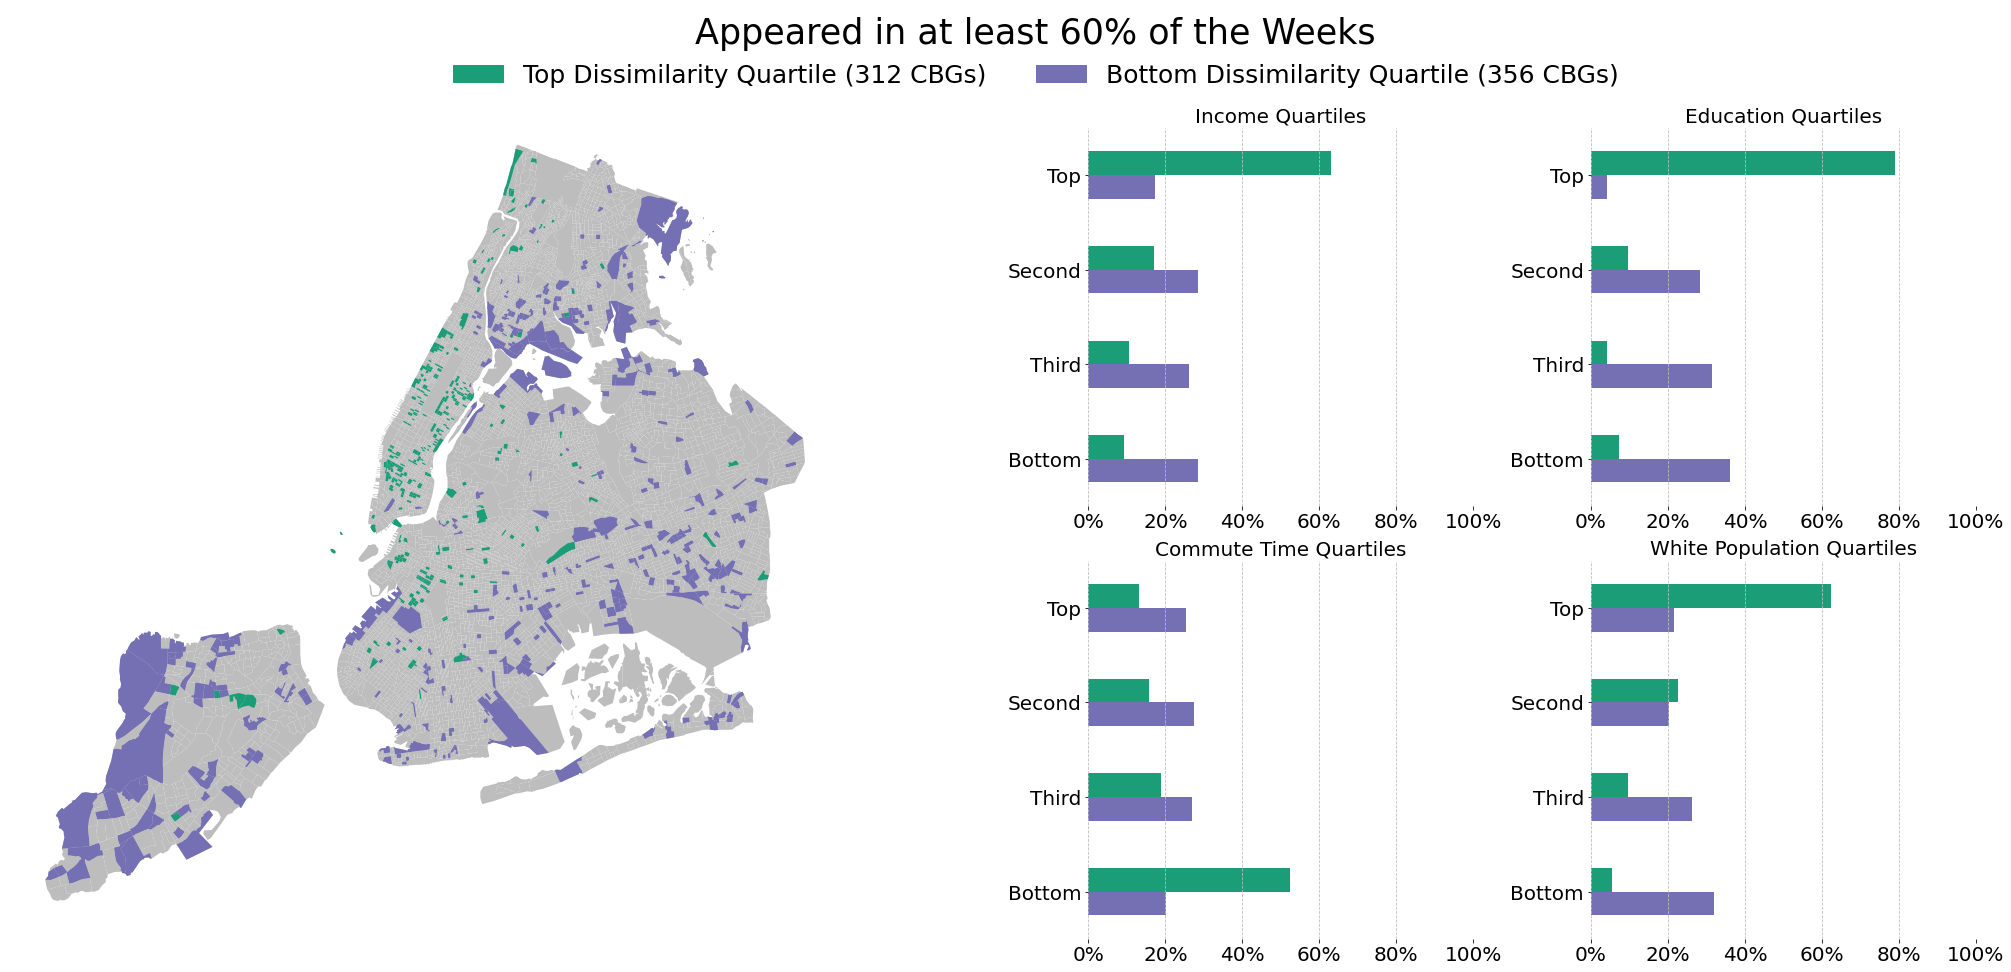

In [58]:
plot_cbgs_bar(top_cbgs, bottom_cbgs)#, fname=f'cbg-change-combined-{threshold}-first-wave.png')

In [59]:
# fig, ax = plt.subplots(figsize=(30, 5))

# ax.plot(dates, np.arange(len(dates)), linestyle='')
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_yticklabels([])
# ax.set_yticks([])

# ax.set_xticklabels([datetime.strptime(d, '%Y-%m-%d').strftime('%b %d, %Y') if i == 0 or i == len(dates) - 1 
#                     else datetime.strptime(d, '%Y-%m-%d').strftime('%b %d')
#                     for i, d in enumerate(dates)])
# ax.tick_params(axis='both', which='major', labelsize=18, length=15)
# fig.savefig('timeline.png')